In [1]:
# Import python packages
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval

%matplotlib inline

In [2]:
# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
# Define the dataId
dataId = {'band': 'i', 'visit': 512055, 'detector': 75}

# For DC2 gen3, these are the only optoins
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'

# Use the butler to get the calexp
butler = Butler(repo, collections=collection)
registry = butler.registry

registry.expandDataId(dataId)
calexp = butler.get('calexp', dataId)


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/obs_base/22.0.1-29-ge050cc6+6e21b5568a/python/lsst/obs/base/formatters/fitsExposure.py:623: UserWarning: Data ID {instrument: 'LSSTCam-imSim', detector: 75, visit: 512055} is missing (implied) value(s) for ['band', 'physical_filter']; the correctness of this Exposure's FilterLabel cannot be guaranteed. Call Registry.expandDataId before Butler.get to avoid this.
  warnings.warn(f"Data ID {self.dataId} is missing (implied) value(s) for {missing}; "


In [8]:
import lsst.pipe.tasks.fakes as fakes

In [42]:
from collections import namedtuple
positionTuple = namedtuple("positionTuple", "y x")

# Ground truth position and intensities for the fake sources
fakeSources = [(positionTuple(800, 455), 11342),
               (positionTuple(800, 350), 18235),
               (positionTuple(834, 379), 13574),
               (positionTuple(834, 442), 12456)]


In [43]:
orig_calexp = calexp.clone()

Using this as an example: https://github.com/lsst/pipe_tasks/blob/387f8f07a2b66205f9fa6bda9a89dcdbbef3f64c/tests/test_fakeProcessing.py

In [44]:
# make stars at a given position with a given intensity
def makeFakeStar(position, intensity, psf):
    psfImage = psf.computeImage(geom.Point2D(position.x, position.y)).getArray()
    psfImage *= intensity
    noise = np.random.normal(0, np.sqrt(abs(psfImage)))
    return psfImage + noise, noise

In [45]:
# Fetch objects from the exposure
psf = calexp.getPsf()
image = calexp.getMaskedImage().getImage()
mask = calexp.getMaskedImage().getMask()
variance = calexp.getMaskedImage().getVariance()

y0 = image.getY0()
x0 = image.getX0()

# Bitplane to set corresponding to the FAKE bit
# fakeMaskValue = 2**mask.getMaskPlaneDict()['FAKE']
fakeMaskValue = 2**12

# At each position create a star with the given intensity and add it
# to the image.
for pos, intensity in fakeSources:
    objArray, noiseArray = makeFakeStar(pos, intensity, psf)
    psfRad = int((objArray.shape[0]-1)/2.)
    yslice, xslice = slice(pos.y-psfRad-y0, pos.y+psfRad+y0+1),\
                     slice(pos.x-psfRad-x0, pos.x+psfRad+x0+1)

    image.getArray()[yslice, xslice] += objArray
    mask.getArray()[yslice, xslice] += fakeMaskValue
    variance.getArray()[yslice, xslice] += noiseArray**2



In [46]:
image0 = image.clone()
print(np.std(image0.getArray()))
image0.getArray()[yslice, xslice] += 5*objArray
print(np.std(image0.getArray()))


503.96432
503.97263


In [47]:
a = image.getArray()[yslice, xslice]
print(np.std(a), np.shape(a))
a += objArray
print(np.std(a), np.shape(a))


137.46382 (41, 41)
169.48904 (41, 41)


In [48]:
xslice

slice(422, 463, None)

In [49]:
diff = image.clone()
diff -= orig_calexp.image

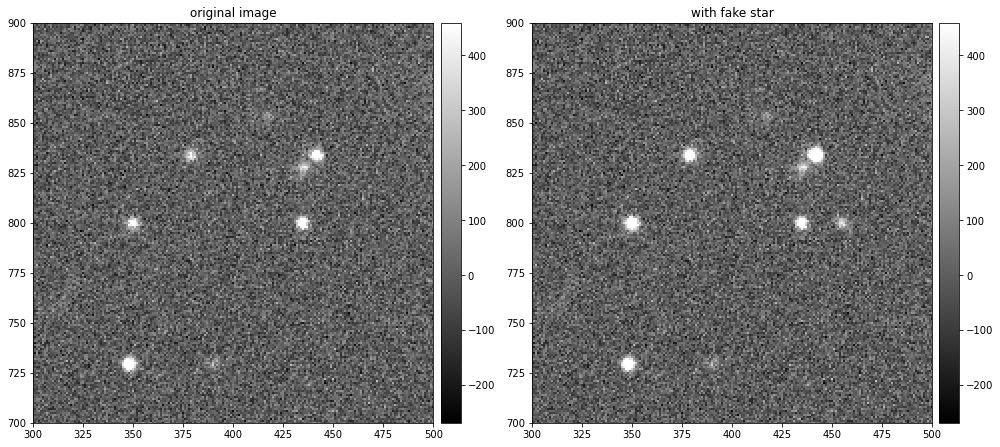

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(orig_calexp.image)
plt.title('original image')
plt.ylim(700, 900)
plt.xlim(300, 500)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(calexp.image)
# display2.mtv(image0)
plt.title('with fake star')
plt.ylim(700, 900)
plt.xlim(300, 500)
plt.tight_layout()
plt.show()
# remove_figure(fig)

In [73]:
# Import tasks from the LSST Science Pipelines
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [92]:
# Create a basic schema to use with these tasks
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

# Create a container which will be used to record metadata about algorithm execution
algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)

algMetadata: 


In [93]:
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(None, config=config)

config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10      # detection threshold in units of thresholdType
config.thresholdType = "stdev"   # units for thresholdValue
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
sourceDeblendTask = SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

In [94]:
tab = afwTable.SourceTable.make(schema)

In [95]:
# Image characterization (this cell may take a few seconds)
result = charImageTask.run(calexp)

psf = calexp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
pixelScale = calexp.getWcs().getPixelScale().asArcseconds()

# The factor of 2.355 converts from std to fwhm
print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-35-gcb622b2d+89d408aa55/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-35-gcb622b2d+89d408aa55/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-35-gcb622b2d+89d408aa55/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-35-gcb622b2d+89d408aa55/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/pipe_tasks/21.0.0-175-g7497abfa+2a6ce44392/python/lsst/pipe/tasks/characterizeImage.py:496: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/pipe_tasks/21.0.0-175-g7497abfa+2a6ce44392/python/lsst/pipe/tasks/characterizeImage.py:497: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfDimensions = psf.computeImage().getDimensions()


psf fwhm = 0.97 arcsec


/tmp/ipykernel_13455/454480901.py:5: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


In [96]:
# Source detection (this cell may take a few seconds)
result = sourceDetectionTask.run(tab, calexp)
type(result)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-35-gcb622b2d+89d408aa55/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-35-gcb622b2d+89d408aa55/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


lsst.pipe.base.struct.Struct

In [97]:
for k, v in result.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
fpSets <class 'lsst.pipe.base.struct.Struct'>
sources <class 'lsst.afw.table.SourceCatalog'>


In [98]:
sources = result.sources

In [99]:
# Source deblending
sourceDeblendTask.run(calexp, sources)

# Source measurement (catch future warning about machine precision)
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_deblender/22.0.1-6-g359a236+7e654c70c6/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


In [100]:
# The copy makes sure that the sources are sequential in memory
sources = sources.copy(True)

# Investigate the output source catalog
sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

In [101]:
near_fakes = (np.abs(sources['base_SdssCentroid_y'] - 800) < 100) & (np.abs(sources['base_SdssCentroid_x'] - 400) < 100)

In [102]:
aaa = sources[near_fakes].copy(deep=True)
len(aaa)

8

In [107]:
print(aaa['base_SdssCentroid_x'], '\n', aaa['slot_PsfFlux_instFlux'])
print(aaa['base_SdssCentroid_y'])
print(fakeSources)

[348.25062168 349.98253258 434.89071188 455.0543968  441.99007339
 379.00205756 442.01671763 435.32250601] 
 [33051.0000121  35475.0336342  22150.43451858 11154.53638978
 50186.7763044  26796.36054423 49789.94738292 11707.19246361]
[729.46220806 799.94496376 800.05868973 800.02764429 833.92132687
 833.94078943 833.94552659 827.68642271]
[(positionTuple(y=800, x=455), 11342), (positionTuple(y=800, x=350), 18235), (positionTuple(y=834, x=379), 13574), (positionTuple(y=834, x=442), 12456)]


In [24]:
from lsst.pipe.tasks.processCcd import ProcessCcdTask
import lsst.pipe.tasks.processCcd as processCcd

In [25]:
# Set ouput path and create a dataId
OutputName = 'temp'
outPath = tempfile.mkdtemp() if OutputName is None \
                             else "{}-ProcessCcd".format(OutputName)
dataId = dict(visit=1)
dataIdStrList = ["{}={}".format(*item) for item in dataId.items()]
mask = None
maskPlaneName = "FAKE" 

In [26]:
processCcdConfig = processCcd.ProcessCcdConfig
processCcdConfig.calibrate.doInsertFakes = True

In [27]:
processCcdConfig = ProcessCcdTask.ConfigClass()
processCcdConfig.calibrate.doInsertFakes = True
processCcdTask = ProcessCcdTask(None, config=processCcdConfig)

TypeError: Can't instantiate abstract class BaseFakeSourcesTask with abstract methods run

In [ ]:
ProcessCcdTask?